In [5]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_colwidth', 200)

In [3]:
# Чтение данных
data = pd.read_csv('datasets.csv', encoding='utf-8')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head(3)

,text,sentiment
0,"Развода на деньги нет\nНаблюдаюсь в Лайфклиник по беременности, развода на деньги нет, врачи не плохие, по поводу ресепшен соглашусь (путают документы).\n",1
1,"Отель выбрали потому что рядом со стадионом. Отель 4*. Номер большой. Кровать 2-спальная одна. 2 одеяла. Много подушек. Есть зона отдыха. Чайный сет. 2 бутылки по 0,5 л бесплатно каждый день. Мног...",0
2,"Вылечили\nГноился с рождения глазик, в поликлинике назначили лечение, не помогло сходили сюда вылечили (офтальмолог Боброва - очень понравилась, все рассказала показала несколько раз как, что прав...",1


# Часть 0. EDA

Объем данных

In [6]:
print('Количество строк в датасете:', data.shape[0])

Количество строк в датасете: 210989


Пропущенные значения

In [75]:
data.isna().sum()

text         0
sentiment    0
dtype: int64

Как видим, в данных нет пропусков.

Распределение по классам

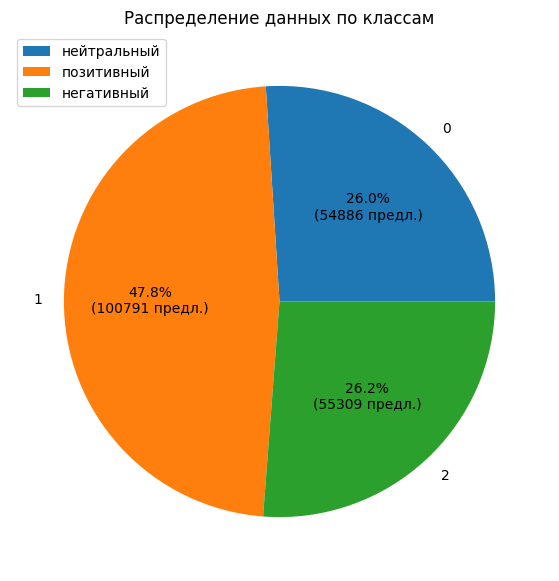

In [56]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} предл.)".format(pct, absolute)

classes_distribution = data.groupby('sentiment').count()
plt.figure(figsize=(12, 7))

plt.pie(x = classes_distribution.text, 
        labels = classes_distribution.index,
        autopct = lambda pct: func(pct, classes_distribution.text))
plt.title('Распределение данных по классам')
plt.legend(['нейтральный', 'позитивный', 'негативный'],
           loc = 'upper left')
plt.show()

В представленных данных 3 класса. Классы характеризуют эмоциональную окраску предложений: 
- класс 0 - нейтральные, 
- класс 1 - позитивные,
- класс 2 - негативные.  

Данные несбалансированы: преобладают позитивно окрашенные предложения.

Визуализируем частоту наиболее частых слов в корпусе

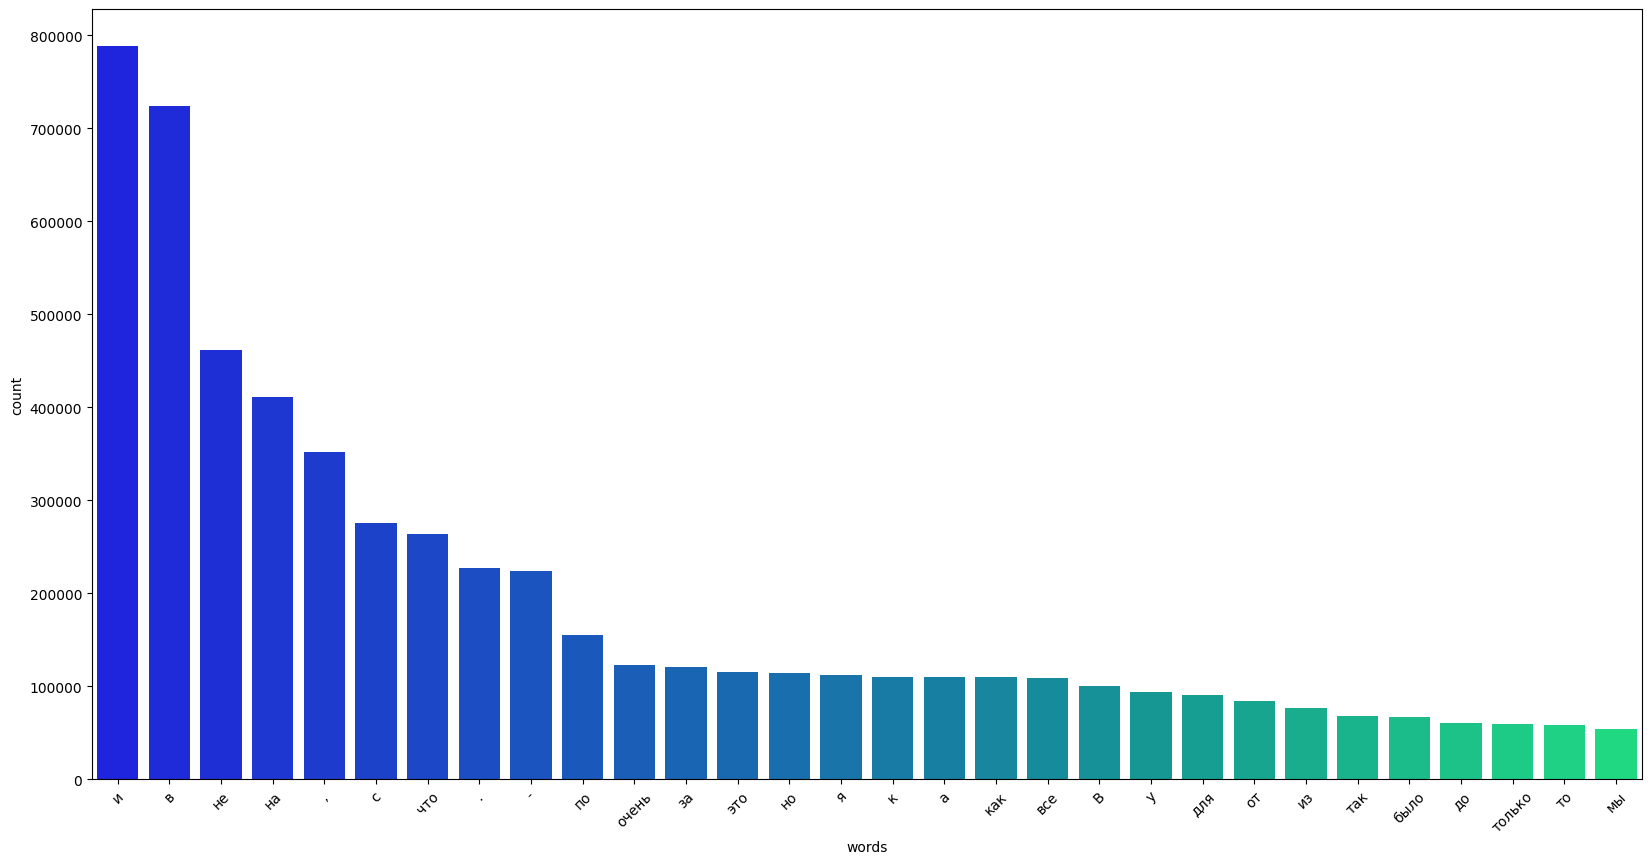

In [73]:
from collections import Counter

text_words = ','.join(list(data['text'].values))

Counter = Counter(text_words.split())
most_frequent = Counter.most_common(30)

fig = plt.figure(1, figsize = (20, 10))
_ = pd.DataFrame(most_frequent, columns=("words", "count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45)
plt.show()

Немного почистим данные и уберем лишние `\n` из строк.

In [53]:
def no_backslash_n(s):
    reg = re.compile('(\.)*\n')
    return re.sub(reg, '.', s)

data['cleaner_text'] = data['text'].apply(no_backslash_n)

# Часть 1. Тематическое моделирование

Для тематического моделирования я выбрал алгоритм неотрицательной матричной факторизации (NMF). В отличие от своего прямого конкурента, алгоритма латентного размещения Дирихле (LDA), NMF не требует предварительного знания числа рубрик, что является большим преимуществом в решаемой задаче. Также, В отличие от LDA, NMF часто дает более интерпретируемые результаты благодаря неотрицательности элементов матриц (важности слов в текстах).

Однако, учитывая размеры датасета, NMF не проходит по памяти, если не передавать в него параметр n_components (еще и не очень большое значение). Это понятно, поскольку без него NMF вынужден хранить в памяти всю матрицу tf-idf, а для более чем двухсот тысяч документов (предложений) размер матрицы исчисляется сотнями миллиардов значений, и ни в какую память такая матрица не поместится. Так что придется экспериментировать с числом тем, начну с 15. Буду также использовать NMF из-за приведенного выше преимущества. 

Предобработка текста

In [21]:
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA

from wordcloud import WordCloud

Очистим текст и проведем лемматизацию - в дальнейшем это пригодится.

In [42]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
stopwords_ru.remove('не') # Оставляю их для более точной классификации в следующем задании. По моему мнению, отзывы с частыми отрицаниями,
stopwords_ru.remove('нет') # скорее всего, являются негативными.
morph = MorphAnalyzer()

# функция лемматизации - разбиваем предложения на токены (слова), далее удаляем токены из списка стоп-слов, 
# нормализуем оставшиеся и собираем предложение обратно
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []

    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)

    tokenized_sent = ' '.join(tokens)
    return tokenized_sent

In [15]:
data['lemmatized_text'] = data['cleaner_text'].apply(lemmatize)
data.dropna(inplace=True)

Моделирование на предложениях с лемматизацией

In [24]:
tfidf_vect_lemm = TfidfVectorizer(max_df=0.8, min_df=2)

# Получаем матрицу tf-idf
doc_term_matrix_lemm = tfidf_vect_lemm.fit_transform(data['lemmatized_text'].values)
doc_term_matrix_lemm.shape

(210876, 110543)

In [74]:
nmf = NMF(random_state=42, n_components=15)
nmf.fit(doc_term_matrix_lemm)

for i, topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect_lemm.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['останавливаться', 'находиться', 'море', 'расположить', 'стамбул', 'персонал', 'бассейн', 'завтрак', 'пляж', 'отель']


Top 10 words for topic #1:
['но', 'просто', 'который', 'сказать', 'нет', 'мочь', 'человек', 'такой', 'это', 'не']


Top 10 words for topic #2:
['ваш', 'выразить', 'весь', 'доктор', 'большой', 'хотеть', 'вы', 'благодарность', 'огромный', 'спасибо']


Top 10 words for topic #3:
['еда', 'зал', 'вкусный', 'свадьба', 'официант', 'блюдо', 'мы', 'обслуживание', 'кухня', 'ресторан']


Top 10 words for topic #4:
['врач', 'отношение', 'больной', 'лежать', 'медсестра', 'палата', 'благодарность', 'операция', 'больница', 'отделение']


Top 10 words for topic #5:
['рк', 'страна', 'национальный', 'развитие', 'компания', 'ао', 'тенг', 'банк', 'казахстан', 'год']


Top 10 words for topic #6:
['кабинет', 'прийти', 'пациент', 'анализ', 'очередь', 'регистратура', 'узи', 'поликлиника', 'приём', 'врач']


Top 10 words for topic #7:
['соотношение', 'место', 'завт

Выделенные 15 тем можно разделить на 5 (возможно, 6, если с негативными отзывами (!), или даже 8, если брать отдельно больницы, стоматологии и поликлиники) основных категорий: темы 0, 7, 8 и 13 посвящена отзывам об отелях, темы 3 и 9 - отзывам о ресторанах, тема 5 - политическим и экономическим событиям Казахстана, темы 2, 4, 6, 11, 12, 14 - отзывам о больницах (в частности, тема 11 похожа на отзыв конкретно о стоматологии, а тема 12 - на отзыв о роддоме), тема 10 - автомобили. Смысл темы 1 не прослеживается (UPD: скорее всего, это негативные отзывы).  
Итого: 
- отели
- рестораны
- Казахстана
- больница
    - стоматология
    - роддом
- автомобили
- негативные отзывы  

Необходимо провести моделирование уже на очищенных текстах: лемматизация снизит общее число слов в словаре за счет приведения слов к нормальной форме, а удаление стоп-слов поможет избежать ситуации с нулевой темой. Также я понижу параметр n_components для более тщательного моделирования.

Моделирование на очищенных и лемматизованных предложениях

In [59]:
nmf_lemm_8 = NMF(n_components=8, random_state=42)
nmf_lemm_8.fit(doc_term_matrix_lemm)

topic_words_nmf_8 = []

for i, topic in enumerate(nmf_lemm_8.components_):
    print(f'Tоп 10 слов для темы #{i}:')
    print([tfidf_vect_lemm.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    top_30_topic_words = [tfidf_vect_lemm.get_feature_names_out()[i] for i in topic.argsort()[-30:]]
    topic_words_nmf_8.append(top_30_topic_words)
    print('\n')

Tоп 10 слов для темы #0:
['центр', 'расположение', 'метро', 'рядом', 'персонал', 'хороший', 'очень', 'завтрак', 'номер', 'отель']


Tоп 10 слов для темы #1:
['но', 'просто', 'сказать', 'мочь', 'который', 'нет', 'такой', 'человек', 'это', 'не']


Tоп 10 слов для темы #2:
['доктор', 'выразить', 'большой', 'весь', 'хотеть', 'вы', 'отделение', 'огромный', 'благодарность', 'спасибо']


Tоп 10 слов для темы #3:
['блюдо', 'хороший', 'мы', 'вкусно', 'вкусный', 'обслуживание', 'кухня', 'понравиться', 'ресторан', 'очень']


Tоп 10 слов для темы #4:
['рк', 'страна', 'национальный', 'развитие', 'компания', 'ао', 'тенг', 'банк', 'казахстан', 'год']


Tоп 10 слов для темы #5:
['довольный', 'пломба', 'стоматолог', 'лечить', 'очень', 'врач', 'доктор', 'лечение', 'зуб', 'клиника']


Tоп 10 слов для темы #6:
['регистратура', 'узи', 'отношение', 'очень', 'анализ', 'больница', 'приём', 'поликлиника', 'ребёнок', 'врач']


Tоп 10 слов для темы #7:
['хороший', 'двигатель', 'км', 'ездить', 'авто', 'очень', 'с

Итого темы:
- отели,
- негативные отзывы
- больницы
- рестораны
- Казахстан
- стоматология
- роддом
- автомобили  

Теперь пришло время визуализировать их.

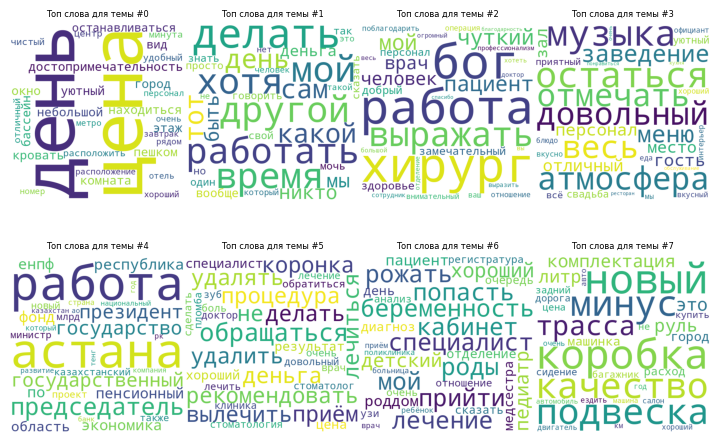

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(7, 7))

for i in range(8):
    txt = " ".join(topic_words_nmf_8[i])

    wordcloud = WordCloud(
        width = 500, 
        height = 500, 
        background_color ='white',
        min_font_size = 6,
        collocations=False).generate(txt)

    ax[i//4, i%4].imshow(wordcloud)
    ax[i//4, i%4].set_axis_off()
    ax[i//4, i%4].set_title(f'Топ слова для темы #{i}', fontsize=6)
    plt.tight_layout(pad = 0)
 
plt.show()

Проверим также разбиение на 5 тем

In [60]:
nmf_lemm_5 = NMF(n_components=5, random_state=42)
nmf_lemm_5.fit(doc_term_matrix_lemm)

for i, topic in enumerate(nmf_lemm_5.components_):
    print(f'Tоп 10 слов для темы #{i}:')
    print([tfidf_vect_lemm.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Tоп 10 слов для темы #0:
['центр', 'расположение', 'метро', 'рядом', 'персонал', 'хороший', 'очень', 'завтрак', 'номер', 'отель']


Tоп 10 слов для темы #1:
['просто', 'который', 'человек', 'мочь', 'такой', 'нет', 'ребёнок', 'сказать', 'это', 'не']


Tоп 10 слов для темы #2:
['лечение', 'весь', 'хотеть', 'доктор', 'огромный', 'отделение', 'клиника', 'благодарность', 'спасибо', 'врач']


Tоп 10 слов для темы #3:
['хороший', 'спасибо', 'вкусно', 'мы', 'вкусный', 'обслуживание', 'кухня', 'понравиться', 'ресторан', 'очень']


Tоп 10 слов для темы #4:
['страна', 'компания', 'ао', 'новый', 'банк', 'тенг', 'автомобиль', 'машина', 'казахстан', 'год']




Из пяти выделенных тем: тема 0 - отели, тема 1 - скорее всего негативные отзывы, тема 2 - больницы, тема 3 - рестораны, тема 4 - экономика/политика Казахстана, также сюда затесалась тема с автомобилями. Как мне кажется, разбиение на 8 тем было более удачным, но все же проверим еще разбиение на 6 тем

In [61]:
nmf_lemm_6 = NMF(n_components=6, random_state=4)
nmf_lemm_6.fit(doc_term_matrix_lemm)

for i, topic in enumerate(nmf_lemm_6.components_):
    print(f'Tоп 10 слов для темы #{i}:')
    print([tfidf_vect_lemm.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Tоп 10 слов для темы #0:
['центр', 'расположение', 'метро', 'рядом', 'персонал', 'хороший', 'очень', 'завтрак', 'номер', 'отель']


Tоп 10 слов для темы #1:
['но', 'просто', 'который', 'мочь', 'сказать', 'нет', 'такой', 'человек', 'это', 'не']


Tоп 10 слов для темы #2:
['выразить', 'большой', 'врач', 'весь', 'хотеть', 'вы', 'огромный', 'отделение', 'благодарность', 'спасибо']


Tоп 10 слов для темы #3:
['всё', 'блюдо', 'вкусно', 'хороший', 'вкусный', 'обслуживание', 'кухня', 'понравиться', 'ресторан', 'очень']


Tоп 10 слов для темы #4:
['развитие', 'компания', 'ао', 'новый', 'банк', 'тенг', 'машина', 'автомобиль', 'казахстан', 'год']


Tоп 10 слов для темы #5:
['доктор', 'анализ', 'очень', 'поликлиника', 'ребёнок', 'лечение', 'приём', 'зуб', 'клиника', 'врач']




Особо лучше не стало, темы 2 и 5 очень похожи друг на друга.

А как себя поведет алгоритм LDA?

In [67]:
lda_lemm_8 = LDA(n_components=8, random_state=42)
lda_lemm_8.fit(doc_term_matrix_lemm)

for i, topic in enumerate(lda_lemm_8.components_):
    print(f'Tоп 10 слов для темы #{i}:')
    print([tfidf_vect_lemm.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Tоп 10 слов для темы #0:
['метро', 'расположение', 'рядом', 'персонал', 'хороший', 'не', 'завтрак', 'очень', 'номер', 'отель']


Tоп 10 слов для темы #1:
['проект', 'рк', 'национальный', 'развитие', 'компания', 'ао', 'тенг', 'банк', 'казахстан', 'год']


Tоп 10 слов для темы #2:
['ну', 'тот', 'нет', 'россия', 'свой', 'который', 'такой', 'человек', 'это', 'не']


Tоп 10 слов для темы #3:
['место', 'мы', 'вкусный', 'понравиться', 'официант', 'обслуживание', 'кухня', 'очень', 'не', 'ресторан']


Tоп 10 слов для темы #4:
['весь', 'ебать', 'пиздец', 'блядь', 'дегенерат', 'нахуй', 'привет', 'тред', 'хохлов', 'хохол']


Tоп 10 слов для темы #5:
['уголовный', 'растрата', 'подсудимый', 'пынь', 'адвокат', 'енпф', 'приговор', 'бузгул', 'аурум', 'суд']


Tоп 10 слов для темы #6:
['цена', 'это', 'очень', 'аптека', 'салон', 'год', 'зуб', 'автомобиль', 'не', 'машина']


Tоп 10 слов для темы #7:
['отношение', 'доктор', 'отделение', 'очень', 'ребёнок', 'благодарность', 'клиника', 'спасибо', 'не', 'врач

По темам: 
- 0: отели,
- 1: Казахстан,
- 2: непонятно,
- 3: рестораны,
- 4: ооочень негативные отзывы 
- 5: судебные процессы (судя по словам, казахские судебные процессы)
- 6: аптеки и автомобили
- 7: больницы  

Разбиение алгоритмом NMF дало, как мне кажется, лучший результат

Запишем полученные индексы тем в датасет и посмотрим примеры предложений

In [68]:
topic_values_lemm_8 = nmf_lemm_8.transform(doc_term_matrix_lemm)
topic_values_lemm_5 = nmf_lemm_5.transform(doc_term_matrix_lemm)
topic_values_lemm_6 = nmf_lemm_6.transform(doc_term_matrix_lemm)
topic_values_lemm_8_lda = lda_lemm_8.transform(doc_term_matrix_lemm)

data['topic_nmf_lemm_8'] = topic_values_lemm_8.argmax(axis=1)
data['topic_nmf_lemm_5'] = topic_values_lemm_5.argmax(axis=1)
data['topic_nmf_lemm_6'] = topic_values_lemm_6.argmax(axis=1)
data['topic_lda_lemm_8'] = topic_values_lemm_8_lda.argmax(axis=1)
data.head()

,text,sentiment,cleaner_text,lemmatized_text,topic_nmf_lemm_8,topic_nmf_lemm_5,topic_nmf_lemm_6,topic_lda_lemm_8
0,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,Развода на деньги нет.Наблюдаюсь в Лайфклиник ...,развод деньга нет наблюдаться лайфклиника бере...,6,1,5,7
1,Отель выбрали потому что рядом со стадионом. О...,0,Отель выбрали потому что рядом со стадионом. О...,отель выбрать рядом стадион отель номер большо...,0,0,0,0
2,"Вылечили\nГноился с рождения глазик, в поликли...",1,"Вылечили.Гноился с рождения глазик, в поликлин...",вылечить гноиться рождение глазик поликлиника ...,3,2,5,7
3,Хорошее расположение.С вокзала дошли пешком.Но...,0,Хорошее расположение.С вокзала дошли пешком.Но...,хороший расположение с вокзал дойти пешком ноч...,0,0,0,0
4,"Отличное месторасположение,прекрасный вид,особ...",1,"Отличное месторасположение,прекрасный вид,особ...",отличный месторасположение прекрасный вид особ...,0,0,0,0


Теперь посмотрим, что это за странная тема номер один в решении с пятью темами

In [63]:
topic_1 = data[data['topic_nmf_lemm_5']==1]['text'].values
for s in topic_1[:7]:
    print(s)

Развода на деньги нет
Наблюдаюсь в Лайфклиник по беременности, развода на деньги нет, врачи не плохие, по поводу ресепшен соглашусь (путают документы).

Не было. Это пиздеш ТСа.

Обочина - часть дороги. Такие дела. Про выезд на проезжую часть немного другое. Но, учитывая, что суд, даже верховный, первый раз обвинил обочечника не так давно, пока правы те, кто едут прямо, а тем более, если это велосипедисты с мопедистами.

До качественной медицины нам далеко
Пробовала прикрепиться по беременности к этой чудной ЖК.
Прописка - Москва, муж прописан на ул. Попова (участок Костюк).
В регистратуре регистратор отвечает на вопросы по настроению. Может ответить точно и по делу, а может нахамить и мягко говоря - послать.
Прикрепиться ни с первого, ни со второго раза не удалось, т. к. заведующая данным леч. учреждением постоянно (со слов регистратора) на совещаниях по род. домам. Так, что не факт, что женщины пришедшие в ее приемные часы, застанут Татьяну Алексеевну на месте, больно занят человек. 

Похоже, что в эту тему собраны по большей части негативные отзывы. Отсюда и знание об этой теме в одной из предыдущих ячеек (с пометкой !).  
Посмотрим примеры из разбиения алгоритмом NMF на 8 тем.

In [66]:
print('Разбиение на 8 тем, примеры\n')
for i in range(8):
    cur_topic = data[data['topic_nmf_lemm_8']==i]['text'].values[:3]
    print(f'Тема #{i}:')
    print(*cur_topic, sep='\n')
    print('\n')

Разбиение на 8 тем, примеры

Тема #0:
Отель выбрали потому что рядом со стадионом. Отель 4*. Номер большой. Кровать 2-спальная одна. 2 одеяла. Много подушек. Есть зона отдыха. Чайный сет. 2 бутылки по 0,5 л бесплатно каждый день. Много шкафов. Мини-бар. Утюг и гладильная доска, отдельно прибор для глажки брюк. Санузел общий большой. Ванна, лейка съемная. 2 раковины, фен. Халаты, тапочки. Расширенный пакет косметических средств, даже соль для ванны. Интернет быстрый. Так как этаж высокий был, вид из окна на город. Один недостаток в номере 919: он напротив хозлифта и с утра начинает пользоваться им персонал для обслуживания завтрака на 9 этаже. Очень слышно звон посуды и разговоры. Завтрак не включен, стоит 23 евро. Рядом с отелем есть кафе и subway.
Хорошее расположение.С вокзала дошли пешком.Ночью очень тихо,хотя центр рядом.Наш номер был в башне.Размер комнаты минимальный,практически как кровать.Такая же ванная,вернее душ.Более,чем скромно.Не особо чисто.Зато дивный вид из окна и хоро

Теперь разбиение алгоритмом LDA

In [69]:
print('Разбиение на 8 тем, LDA, примеры\n')
for i in range(8):
    cur_topic = data[data['topic_lda_lemm_8']==i]['text'].values[:3]
    print(f'Тема #{i}:')
    print(*cur_topic, sep='\n')
    print('\n')

Разбиение на 8 тем, LDA, примеры

Тема #0:
Отель выбрали потому что рядом со стадионом. Отель 4*. Номер большой. Кровать 2-спальная одна. 2 одеяла. Много подушек. Есть зона отдыха. Чайный сет. 2 бутылки по 0,5 л бесплатно каждый день. Много шкафов. Мини-бар. Утюг и гладильная доска, отдельно прибор для глажки брюк. Санузел общий большой. Ванна, лейка съемная. 2 раковины, фен. Халаты, тапочки. Расширенный пакет косметических средств, даже соль для ванны. Интернет быстрый. Так как этаж высокий был, вид из окна на город. Один недостаток в номере 919: он напротив хозлифта и с утра начинает пользоваться им персонал для обслуживания завтрака на 9 этаже. Очень слышно звон посуды и разговоры. Завтрак не включен, стоит 23 евро. Рядом с отелем есть кафе и subway.
Хорошее расположение.С вокзала дошли пешком.Ночью очень тихо,хотя центр рядом.Наш номер был в башне.Размер комнаты минимальный,практически как кровать.Такая же ванная,вернее душ.Более,чем скромно.Не особо чисто.Зато дивный вид из окна и

## Итоги

Итого, мне удалось выделить из данных 8 категорий (я отдаю предпочтение именно разбиению от NMF). Однако из выше приведенных примеров видно, что категории выделены не идеально: в теме 3, посвященной ресторанам, есть отзыв о походе к офтальмологу.  

Варианты улучшения:
- более тщательно удалять стоп-слова (например, удалить такие слова, которые встречаются во многих предложениях и несут мало смысла, возможно, имена авторов отзывов)
- попробовать другие алгоритмы (например, аггломеративную кластеризацию или те же модели, но из библиотеки gensim, они реализованы не с помощью tf-idf, а с помощью  биграмм и триграмм. Кстати, для этой библиотеки есть удобный инструмент визуализации pyLDAvis, но для sklearn'овской реализации алгоритмов я не смог применить этот инструмент)
- можно попробовать, используя BERT, вычислить эмбеддинги предложений, и на их основе запустить классические ML алгоритмы классификации/кластеризации

# Часть 2. Классификация

Для классификации предложений я решил использовать модель BERT, которая очень хорошо себя зарекомендовала в задачах NLP в последнее время.  

Для выполнения задачи нужно загрузить модель и токенайзер (я взял модель rubert-tiny с сайта Hugging Face), далее закодировать предложения и получить их векторные представления (эмбеддинги), вектора attention_mask (нужны для корректной работы BERT-модели: attention_mask равна 1 для токенов предложения и 0 для токенов паддинга, то есть во всей оставшейся части вектора, которая нужна чтоюы все эмбеддинги были одной и той же длины). После этого можно приступать к обучению модели. Обучение происходит по стандартному пути обучения нейросети: создаются даталоадеры, выбирается оптимизатор и функция потерь и можно начинать обучение.  

По непонятным для меня причинам датасет не пожелал правильно считаться в google.colab, постоянно выдавая ошибку Unexpected EOF/unable to decode byte at position. Выставление флагов игнорирования ошибок, смена кодировок, добавление параметра `engine='python'`, преобразования строк в датасете, перевод его в txt формат и даже ручной поиск строк с ошибками ничего не дал - в лучшем случае считывалось около 10 тысяч строк, что явно мало для датасета из 210 тысяч строк. Так что, потратив пол дня на попытки заставить colab скушать датасет, я решил запустить обучение на локальной машине. На полный цикл обучения, с использованием всех данных, мне бы не хватило времени, так что я решил обучить маленькую модель и просто показать, что модель обучается и работает как надо.

In [3]:
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True, # Дополняем токенами [SEP] и [CLS]
        max_length=self.max_len, 
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True, # Та самая attention_mask
        return_tensors='pt', # в формате torch.tensor
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [5]:
class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='/content/bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Жаль так и не пригодился :(
        self.model_save_path=model_save_path
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features # Считаем размерность выходного слоя ...
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes) # ... и добавляем слой классификации
        self.model.to(self.device)
    
    def preparation(self, X_train, y_train, X_valid, y_valid):
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # БОльшие батчи не помещаются в память ноутбука
        self.train_loader = DataLoader(self.train_set, batch_size=8, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=8, shuffle=True)

        # Adam - прекрасный оптимизатор, считается одним из наиболее быстрых оптимизаторов для обучения нейросети
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)

        # Планировщик нужен для настройки параметров оптимизатора во время обучения
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
            )

        # Классическая функция потерь для мультиклассовой классификации
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
            
    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0) # Нормируем градиенты, чтобы не было gradient explosion
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    
    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in tqdm(self.valid_loader):
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        
        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss
    
    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        self.model = torch.load(self.model_save_path)
    
    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [6]:
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=3,
        epochs=2,
        model_save_path='bert.pt'
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Отбираем по 5 тысяч семплов каждого класса - зато не нужно балансировать данные :/

In [7]:
data_class_0 = data[data['sentiment']==0].head(5000)
data_class_1 = data[data['sentiment']==1].head(5000)
data_class_2 = data[data['sentiment']==2].head(5000)

data_small = pd.concat([data_class_0, data_class_1, data_class_2])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_small['lemmatized_text'], data_small['sentiment'], test_size=0.2, random_state=42)

classifier.preparation(
    X_train=list(X_train),
    y_train=list(y_train),
    X_valid=list(X_test),
    y_valid=list(y_test)
)

In [14]:
y_train.groupby(y_train.values).count()

0    3963
1    4030
2    4007
Name: sentiment, dtype: int64

Данные сбалансированны

In [10]:
classifier.train()

Epoch 1/2


100%|██████████| 1500/1500 [39:45<00:00,  1.59s/it]


Train loss 0.7558498412867387 accuracy 0.6408333333333334


100%|██████████| 375/375 [03:15<00:00,  1.92it/s]


Val loss 0.6689030408461889 accuracy 0.6986666666666667
----------
Epoch 2/2


100%|██████████| 1500/1500 [37:51<00:00,  1.51s/it]


Train loss 0.6464171638886134 accuracy 0.7075


100%|██████████| 375/375 [02:50<00:00,  2.19it/s]


Val loss 0.6543291128873825 accuracy 0.7026666666666667
----------


Лосс уменьшается, качество растет - модель обучается как надо. Если поставить обучение на бОльшее количество эпох, модель достигнет значительно лучшего качества.  

## Итоги

На данном этапе качество классификации невелико, но, опять же, обучение можно проводить на гораздо большем количестве эпох и данных. На качество обучения также негативно влияет маленький размер батча. Скорость обучения - 12'000 семплов за 40 минут, с GPU не сравнится.  

Варианты улучшения качества и скорости работы:
- решить проблему с чтением данных в colab (даст огромный прирост в скорости обучения модели, также даст возможность обучаться на всех данных сразу, разве что пришлось бы балансировать данные, но тут SMOTE или ADASYN в помощь)
- поэкспериментировать с другими моделями (например, с BERT от DeepPavlov)
- оставить от BERT только эмбеддинги и обучить на них классическую модель машинного обучения (RandomForest или модель бустинга, например XGBoost)
- проводить очистку предложений более точно, например, добавить в список стоп-слов некоторые бесполезные слова из наиболее часто использующихся в корпусе